# MiniEP1 - Aproximação de Integrais usando Médias e Amostragem Uniforme

## Entrega do miniEP1

Preencha o nome dos 5 membros do seu grupo na tabela abaixo:

| Nome | NUSP |
|------|------|
| Caio Andrade | 9797232 |
| Caio Fontes | 10692061 |
| Membro3 | 12345789 |
| Thiago Teixeira | 10736987|
| Membro5 | 12345789 |

**Apenas um dos membros** deverá entregar **este arquivo** `.ipynb`, com as soluções do miniEP1 **feitas pelo grupo**.

## Configuração do Ambiente

A primeira tarefa do miniEP1 é instalar e configurar o ambiente.

### Julia, Jupyter, IJulia

Para fazer o miniEP1, você vai precisar:

- [Instalar o Jupyter Notebook](https://jupyter.readthedocs.io/en/latest/install.html)
- Instalar Julia 1.3:
    - [Baixando o binário](https://julialang.org/downloads/)
    - **ou** [usando seu gerenciador de pacotes](https://julialang.org/downloads/platform/)
- Instalar o pacote *IJulia*:
    - Inicie o interpretador Julia
    - Digite `] add IJulia` e pressione `<ENTER>`
    
Depois disso, você vai conseguir iniciar o arquivo `.ipynb` do miniEP1.

### Pacotes Julia para o miniEP1

Os pacotes necessários para o miniEP1 estão listados no arquivo `Project.toml`, mas você pode instalar e atualizar os pacotes rodando a célula abaixo:

In [ ]:
] up

Verifique o status dos pacotes, e se há algum problema, com o comando:

In [2]:
] st

Status `~/Documentos/Paralela/2020/Project.toml`
  (no changes since last commit)


## Integração por Método de Monte Carlo

O objetivo deste miniEP é relembrar e aplicar alguns conceitos de estatística, independentes de linguagens de programação. Escolhemos usar a linguagem Julia para os experimentos, análises e geração de gráficos, mas a metodologia desenvolvida pode ser usada com qualquer ferramenta.

Você deve ler o texto neste arquivo e ir executando as células de código que encontrar. Assim vai definindo as funções progressivamente e vai gerar gráficos no final. Julia é uma linguagem compilada *Just-in-Time*, e a primeira vez que você executa uma célula pode levar algum tempo. Isso é por que os pacotes estão sendo compilados. A segunda execução da mesma função será mais rápida, verifique!

Vamos estimar o valor de algumas integrais usando o método de integração de Monte Carlo. A intuição por trás do método é que a integral de uma função $f$ pode ser estimada pela média do valor de $f$ num conjunto suficientemente grande de pontos obtidos a partir de uma distribuição uniforme.

Mais formalmente, para um conjunto de pontos $x_1,\dots,x_N$ uniformemente amostrados num intervalo $[a,b]$, a integral de $f$ no intervalo $[a,b]$ pode ser aproximada por:

$$
\int_{a}^{b} f(x)dx \approx \mathbb{E}\left[\left(b - a\right)\dfrac{1}{N}\sum\limits_{i = 1}^{N}{f(x_i)}\right] 
$$

Para uma representação gráfica da intuição, e para a prova dessa aproximação, veja [esta página](https://www.scratchapixel.com/lessons/mathematics-physics-for-computer-graphics/monte-carlo-methods-in-practice/monte-carlo-integration).

O código abaixo define a função `monte_carlo_integrate`, que estima a integral de uma função `f` num intervalo `interval`, usando o método de Monte Carlo com amostras dadas pelo valor de `samples`. O código usa aplicação vetorizada de funções, através da sintaxe `função.(vetor)`, mas os comentários contêm código equivalente de uma versão usando loops. Usamos o pacote `Distributions` para gerar números pseudoaleatórios no intervalo $[a,b]$. Execute a célula abaixo:

In [3]:
using StatsPlots, Distributions, DataFrames, Query

function monte_carlo_integrate(f, interval, samples = 100)
    xs = rand(Uniform(interval[1], interval[2]), samples)
    
    # Using for loops:
    # accumulator = 0
    #
    # for x in xs
    #     accumulator += f(x)
    # end
    #
    # return accumulator / samples
    
    # Using vectorized function application:
    return sum(f.(xs)) / samples
end

monte_carlo_integrate (generic function with 2 methods)

### Primeiro Exemplo

Usamos a função `make_f1` abaixo para encapsular o parâmetro $a$ de uma função definida por:

$$
f_1(x) = \dfrac{2}{\sqrt{a ^ 2 - x ^ 2}}
$$

Se quiser saber mais, leia sobre [funções anônimas em Julia](https://docs.julialang.org/en/v1/manual/functions/#man-anonymous-functions-1).

Usando $a = 1$, definimos a função `f1`. A integral da função $f_1$, definida acima, é [dada por](https://en.wikipedia.org/wiki/List_of_definite_integrals#Definite_integrals_involving_rational_or_irrational_expressions):

$$
\int_{0}^{a}{f_1(x)dx} = \int_{0}^{a}{\dfrac{2}{\sqrt{a ^ 2 - x ^ 2}}dx} = \pi
$$

Vamos estimar a integral da função $f_1$ usando o método de Monte Carlo. Execute a célula abaixo:

In [4]:
function make_f1(a)
    return x -> 2 / (sqrt((a ^ 2) - (x ^ 2)))
end


a = 1
f1 = make_f1(a)

#3 (generic function with 1 method)

### Executando Experimentos e Gerando Resultados

A função `run_experiments` recebe uma função alvo `target_f`, um intervalo `interval`, um número de amostras `samples`, e a quantidade de repetições da estimação `repetitions` que devem ser feitas. A função devolve uma [estrutura do tipo `DataFrame`](https://juliadata.github.io/DataFrames.jl/stable/), que é essencialmente uma matriz com colunas nomeadas e de tipo fixo.

Abstrações como os `DataFrames` são extremamente úteis para representar dados tabelados, e são muito usadas em computação científica e em experimentos computacionais em geral. As linguagens [Python](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) e [R](https://www.rdocumentation.org/packages/base/versions/3.6.2/topics/data.frame) também têm abstrações equivalentes.

Nossa função "cresce" um `DataFrame` linha a linha, à medida que executa os experimentos. É prática comum repetir parâmetros para os experimentos, como a coluna `func` do nosso `DataFrame`, pois assim podemos misturar experimentos diferentes numa mesma estrutura.

In [5]:
function run_experiments(target_f, interval, samples, repetitions)
    results = DataFrame(func = String[], samples = Int[], integral = Float64[])
    
    for s in samples
        for r in 1:repetitions
            append!(results, DataFrame(func = ["target_f"],
                    samples = [s],
                    integral = monte_carlo_integrate(target_f, interval, s)))    
        end
    end
    
    return results
end

results = run_experiments(f1, [0, a], [10 ^ x for x in 0:5], 20)

,func,samples,integral
,String,Int64,Float64
1,target_f,1,3.35085
2,target_f,1,2.05757
3,target_f,1,2.01186
4,target_f,1,2.73002
5,target_f,1,2.49025
6,target_f,1,3.96037
7,target_f,1,2.01363
8,target_f,1,7.89942
9,target_f,1,2.13401


### Estimando a Integral e Manipulando os Resultados

Ao repetir a estimativa de uma integral para um número fixo de amostras, esperamos observar propriedades interessantes da variação do valor estimado. Neste miniEP, vamos nos preocupar com a *média* e o *desvio padrão* das amostras, e vamos calcular um *intervalo de confiança* de 95%.

A função `parse_results` recebe um `DataFrame` gerado pela função `run_experiments`, e gera um novo `DataFrame` com os valores da média e intervalo de confiança 95% das estimativas repetidas.

Utilizamos o operador *pipe* `|>` e pacote [Query](https://www.queryverse.org/Query.jl/stable/) para fazer os cálculos. O operador `|>` é binário, e seu significado é "*passe o argumento da esquerda como primeiro parâmetro da função à direita*":

In [6]:
? |>

search: |>



```
|>(x, f)
```

Applies a function to the preceding argument. This allows for easy function chaining.

# Examples

```jldoctest
julia> [1:5;] |> x->x.^2 |> sum |> inv
0.01818181818181818
```


A [macro](https://docs.julialang.org/en/v1/manual/metaprogramming/#man-macros-1) `@groupby` agrupa as linhas de um `DataFrame` pela variável passada como parâmetro. O caractere `_` faz referência ao `DataFrame` passado pelo operador `|>`.

A macro `@map` recebe um dicionário de funções, onde a chave será uma coluna do novo `DataFrame`, e o valor é uma função envolvendo ou não as colunas originais.

A função de chave `mean_integral`, por exemplo, calcula a média dos valores da coluna `integral` original, agrupada por `samples`. A coluna `ci_estimate`, por sua vez, conterá uma estimativa do intervalo de confiança 95%.

O operador `|>` e o pacote Query permitem escrever código muito similar ao produzido pela [biblioteca dplyr](https://dplyr.tidyverse.org/) da linguagem R. Execute a célula abaixo:

In [7]:
function parse_results(results, target_integral)
    parsed_results = results |>
                    @groupby(_.samples) |>
                    @map({samples = key(_),
                          mean_integral = mean(_.integral),
                          ci_estimate = 1.96 * std(_.integral),
                          target = target_integral}) |>
                    DataFrame
    
    return parsed_results
end

parsed_results = parse_results(results, pi)

,samples,mean_integral,ci_estimate,target
,Int64,Float64,Float64,Irration…
1,1,3.11243,3.87343,π
2,10,3.72209,3.20486,π
3,100,3.12046,0.441091,π
4,1000,3.14903,0.17241,π
5,10000,3.14555,0.0610807,π
6,100000,3.14046,0.0308821,π


### Análise Visual: Gerando Gráficos

A função `plot_raw_results` gera um gráfico com cada uma das repetições da estimativa do valor da integral, no eixo y, para cada uma das quantidades de repetições, no eixo x. Usamos o [pacote Plots](https://docs.juliaplots.org/latest/) para gerar os gráficos.

Para o miniEP1, você não precisa escrever seus próprios gráficos, mas recomendamos fortemente que você aprenda alguma biblioteca de plotagem, pois vai precisar delas nos EPs seguintes.

Sugerimos aprender uma das seguintes bibliotecas:

- [ggplot2](https://ggplot2.tidyverse.org/) (R)
- [matplotlib](https://matplotlib.org/) (Python)
- [Plots](https://docs.juliaplots.org/latest/) (Julia)

Todas essas bibliotecas podem ser usadas em Notebooks Jupyter. Execute a célula abaixo:

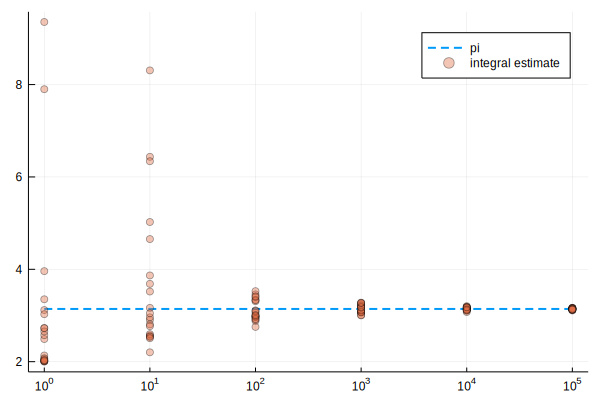

In [8]:
function plot_raw_results(parsed_results, target_label)
    plot(parsed_results.samples,
         parsed_results.target,
         labels = target_label,
         line = :dash,
         width = 2.0)
    scatter!(results.samples,
             results.integral,             
             xscale = :log10,
             alpha = 0.4,
             labels = "integral estimate")
end

plot_raw_results(parsed_results, "pi")

### Exercícios

Os exercícios procuram revisitar conceitos de estatística básica, dando a oportunidade de analisar qualitativa e quantitativamente resultados de experimentos computacionais. A metodologia exercitada aqui será útil nos EPs subsequentes, e em casos futuros onde a análise de experimentos seja necessária.

#### Exercício 1

**a)** Execute a célula acima para gerar o gráfico. Observando o gráfico gerado, descreva *qualitativamente* o comportamento das estimativas da integral, em relação ao seu valor esperado, à medida que aumentamos o número de pontos amostrados. Use a célula abaixo para escrever sua resposta.

**R:** O gráfico acima evidencia que, para uma determinada função integrável num determinado intervalo, quanto maior o tamanho da amostra, isto é, quanto maior a quantidade de pontos no intervalo em questão para os quais se calculará o valor da função a ser integrada, mais a média desses valores se aproxima do verdadeiro valor da integral no respectivo intervalo.

**b)** Leia o verbete sobre [valor esperado](https://en.wikipedia.org/wiki/Expected_value) na Wikipedia, e escreva um parágrafo definindo a média de uma amostra. Como podemos interpretar a média? Escreva uma fórmula em $\LaTeX$ para a média.

**R:** Podemos definir a média de uma amostra como a soma dos valores de cada valor individual da amostra didividos pelo número de valores amostrados.

Podemos interpretar a média como o valor esperado da função de distribuição que teóricamente rege nossa amostra, isso se dá pelo fato de que valores que repetem são somados mais vezes, o que acaba produzindo o mesmo efeito de multiplicar o valor por um número maior para indicar a sua probabilidade.

Fórmula:

$$
X_{média} = \frac{1}{N}\sum^{N}_{i=1}x_i
$$

**c)** Leia o verbete sobre [intervalo de confiança](https://en.wikipedia.org/wiki/Confidence_interval) na Wikipedia, e escreva um parágrafo com uma **descrição da intuição** por trás da definição de intervalo de confiança. Explique também a relação entre a variância estimada de uma amostra, o desvio padrão, e o intervalo de confiança a 95%.

Escreva fórmulas em $\LaTeX$ para a variância e o desvio padrão, mas não se preocupe com a formalização da definição do intervalo de confiança, estamos interessados na intuição por trás da ideia.

**R:** Na investigação (por inferencia) estatística de um determinado valor, um intervalo de confiança consiste de um intervalo fechado de valores - gerado a partir de uma determinada regra - para o qual há uma alta probabilidade (por exemplo, 95%) de que o valor real da variável sendo investigada esteja contido nesse intervalo.

Desvio padrão:

$$
\sigma^2 = \bigg( \frac{\displaystyle\sum_{i=1}^{n}(x_i - X_{média})^2} {n} \bigg)^2
$$

As fronteiras do intervalo de confiança podem ser definidas como:
$$
x \in \{ X_{Média} +- z*\frac{\sigma}{\sqrt{N}}\}
$$

Onde $z$ é um valor definido pela distribuição $N(0,1)$ O $z$ de uma observação é o número de desvios padrões de distância da média. Normalmente se utiliza $z = 1.96$ para intervalos de confiança com 95% de probabilidade.

**d)** A função `plot_results` gera um gráfico sumarizando os dados da figura anterior. O gráfico gerado mostra a média das estimativas e o intervalo de confiança 95%, calculados anteriormente.

Execute a célula abaixo e gere o gráfico. Interprete os resultados *quantitativamente*, em termos da média e do intervalo de confiança. Responda também:

1. Esse é o comportamento que você esperava para a estimativa pelo método de Monte Carlo? Por que?
2. Que engano poderíamos cometer, se não calculássemos o intervalo de confiança?

**R:** Temos que o intervalo de confiança tende a diminuir conforme o número de amostras se aproxima da média, isso se deve ao denominador $\sqrt N$ no cálculo dos extremos do intervalo. A média mostra um comportamento similar, conforme N tende ao infinito (maior número de amostras) podemos observar que a média se aproxima do valor esperado, se aproximando do valor real da integral.


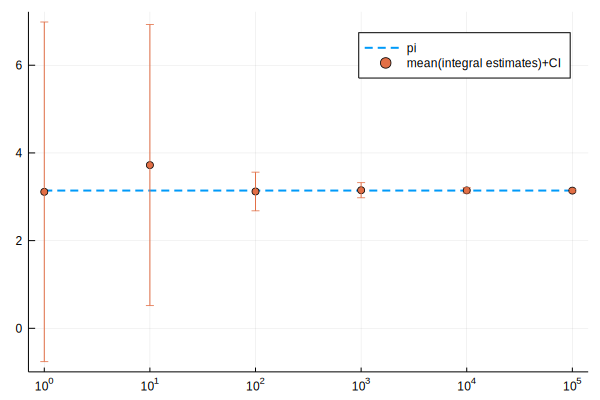

In [9]:
function plot_results(parsed_results, target_label)
    plot(parsed_results.samples,
         parsed_results.target,
         labels = target_label,
         line = :dash,
         width = 2.0)
    scatter!(parsed_results.samples,
             parsed_results.mean_integral,             
             yerror = parsed_results.ci_estimate,        
             xscale = :log10,        
             labels = "mean(integral estimates)+CI")
end

plot_results(parsed_results, "pi")

#### Exercício 2

**a)** Implemente em Julia a [função descrita abaixo](https://towardsdatascience.com/monte-carlo-integration-is-magic-c7f817d89610):

$$
f_2(x) = 2xe^{x^2}
$$

A integral de $f_2$ é dada por:

$$
\int_{0}^{1}{f_2(x)dx} = \int_{0}^{1}{2xe^{x^2}}dx = e - 1
$$

Vamos estimar essa integral usando método de Monte Carlo. Use a célula abaixo, e apenas complete a definição de `f2`. Execute a célula.

In [10]:
function f2(x)
    return 2*x*exp(x^2)
end


results = run_experiments(f2, [0.0, 1.0], [10 ^ x for x in 0:5], 30)
parsed_results = parse_results(results, Base.MathConstants.e - 1)

,samples,mean_integral,ci_estimate,target
,Int64,Float64,Float64,Float64
1,1,1.72378,2.68319,1.71828
2,10,1.85414,0.863387,1.71828
3,100,1.685,0.299047,1.71828
4,1000,1.70827,0.101275,1.71828
5,10000,1.72179,0.0272904,1.71828
6,100000,1.71794,0.00946672,1.71828


**b)** Gere as duas figuras, executando as células abaixo. Interprete os resultados *quantitativamente*, como fez no exercício **1d**. Escreva sua resposta na célula abaixo.

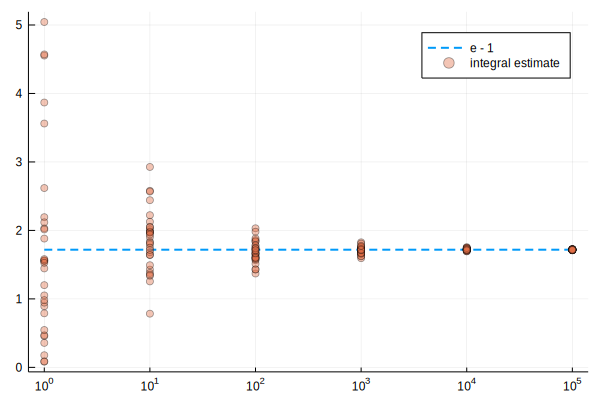

In [11]:
plot_raw_results(parsed_results, "e - 1")

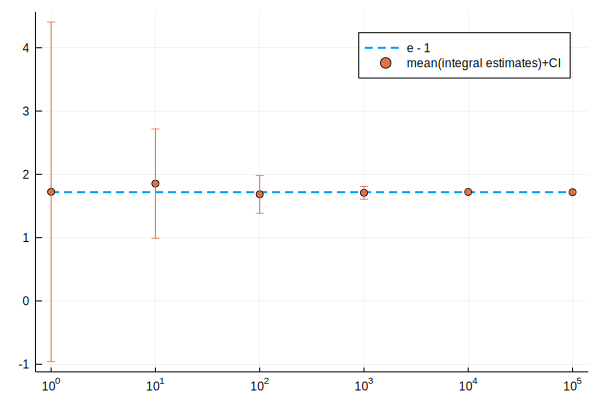

In [12]:
plot_results(parsed_results,"e - 1")

R: Nos primeiro gráficos podemos observar que os resultados estão bem "espalhadas" pelo eixo $y$, isso reflete o valor alto da variância em experimentos feitos com um número pequeno de amostragens. Isso também se reflete nos intervalos de confiança mostrados no gráfico 2.

Conforme o número de amostras aumenta, tanto a variância quanto a amplitude do intervalo de confiança mostram uma diminuição similar.

Temos que no caso com $10^0$ amostras temos um intervalo de confiança que se extende a vlaores negativos, mesmo que nenhum resultado experimental os atinja (visto que são somas de números positivos).

**c)** Implemente em Julia a [função abaixo](https://en.wikipedia.org/wiki/Euler%E2%80%93Mascheroni_constant#Integrals):

$$
f_3(x) = \dfrac{1}{\text{ln}x} + \dfrac{1}{1 - x}
$$

A integral de $f_3$ é dada por:

$$
\int_{0}^{1}{f_3(x)dx} = \int_{0}^{1}{\left(\dfrac{1}{\text{ln}x} + \dfrac{1}{1 - x}\right)dx} = \gamma
$$

Use a célula abaixo, e apenas complete a definição de `f3`. Execute a célula.

In [13]:
function f3(x)
    return 1/log(x) + 1/(1-x)
end

results = run_experiments(f3, [0.0, 1.0], [10 ^ x for x in 0:5], 20)
parsed_results = parse_results(results, Base.MathConstants.eulergamma)

,samples,mean_integral,ci_estimate,target
,Int64,Float64,Float64,Irration…
1,1,0.563434,0.108518,γ
2,10,0.579653,0.0497918,γ
3,100,0.576854,0.0115102,γ
4,1000,0.575997,0.00434589,γ
5,10000,0.57717,0.00121618,γ
6,100000,0.577232,0.000381079,γ


**d)** Gere as duas figuras, executando as células abaixo. Interprete os resultados *quantitativamente*, como fez no exercício **1d**. Escreva sua resposta na célula abaixo.

Podemos observar a mesma convergência dos valores experimentais e do intervalo de confiança que foi vista nos outros exemplos, confirmando as hipóteses teóricas sobre esse método.

Também observamos que nesse exemplo a gama de valores dos experimentos é menor, o que se reflete nos valores o intervalo de confiança.

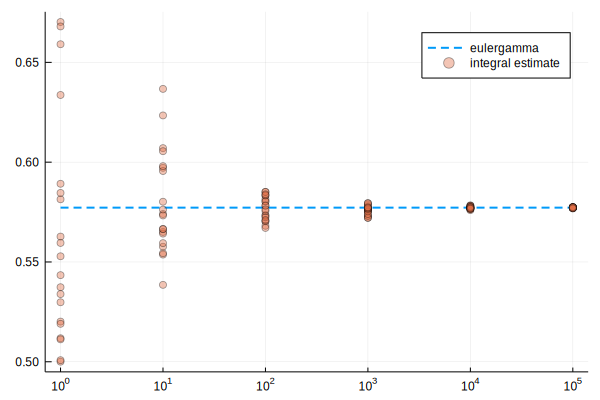

In [14]:
plot_raw_results(parsed_results, "eulergamma")

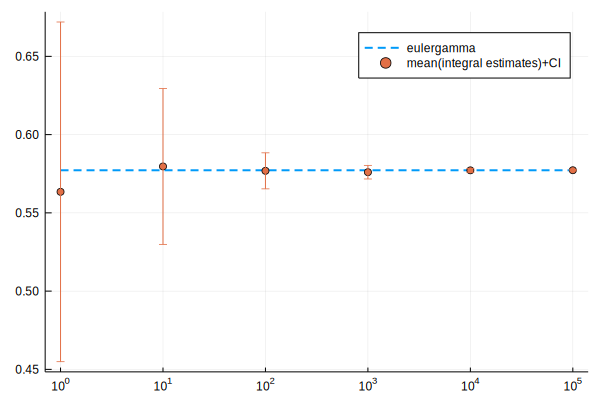

In [15]:
plot_results(parsed_results, "eulergamma")